In [1]:
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
# ----------------------
# Setup data
# ----------------------
df = pd.read_csv("./iot-dataset/iot-train-set.csv", sep=";")
unused_features = ['timestamp', 'zone_id', "day_of_week", 'temperature_celsius', 'special_event_flag']
categorical_cols = [ "time_of_day", "weather_condition"]
df.drop(unused_features, axis=1, inplace=True)
X = df.drop("lighting_action_class", axis=1)
y = df["lighting_action_class"]

# Identify numeric columns
numeric_cols = [col for col in X.columns if col not in categorical_cols]

# Preprocessing: one-hot encode categoricals
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols)
    ]
)

# ----------------------
# Define tree-based models
# ----------------------
models = {
    "NaiveBayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=3),
    "DecisionTree": DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(random_state=42, class_weight="balanced", n_jobs=-1),
    "ExtraTrees": ExtraTreesClassifier(random_state=42, class_weight="balanced", n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "HistGradientBoosting": HistGradientBoostingClassifier(random_state=42)
}

# ----------------------
# Cross-validation
# ----------------------
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

results = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                               ("classifier", model)])
    
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring="f1_macro")
    results[name] = {
        "mean_f1": np.mean(scores),
        "std_f1": np.std(scores)
    }

# ----------------------
# Show results
# ----------------------
for name, res in results.items():
    print(f"{name}: F1_macro = {res['mean_f1']:.3f} ± {res['std_f1']:.3f}")

NaiveBayes: F1_macro = 0.804 ± 0.020
KNN: F1_macro = 0.777 ± 0.019
DecisionTree: F1_macro = 0.839 ± 0.021
RandomForest: F1_macro = 0.870 ± 0.026
ExtraTrees: F1_macro = 0.852 ± 0.022
GradientBoosting: F1_macro = 0.879 ± 0.022
HistGradientBoosting: F1_macro = 0.872 ± 0.021


<Figure size 600x500 with 0 Axes>

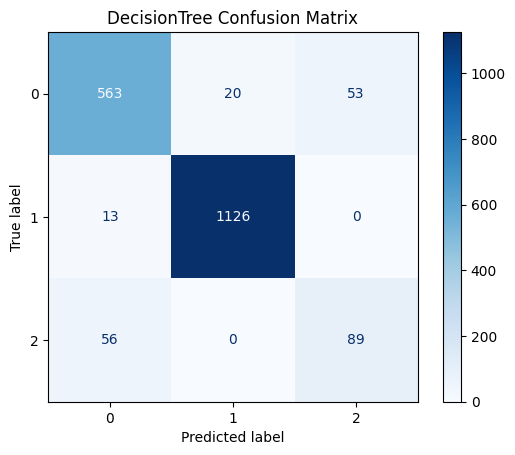

<Figure size 600x500 with 0 Axes>

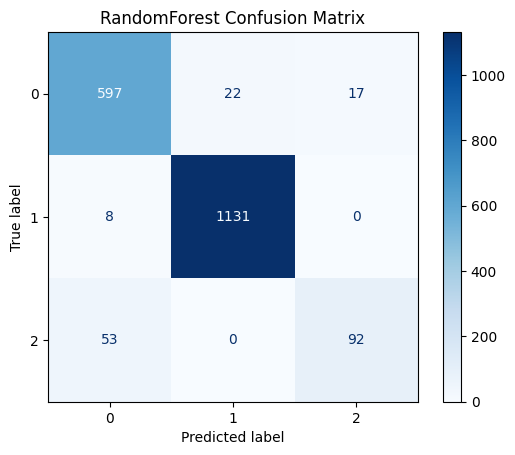

<Figure size 600x500 with 0 Axes>

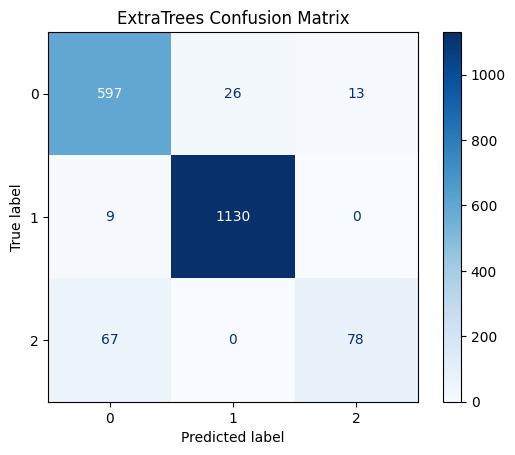

<Figure size 600x500 with 0 Axes>

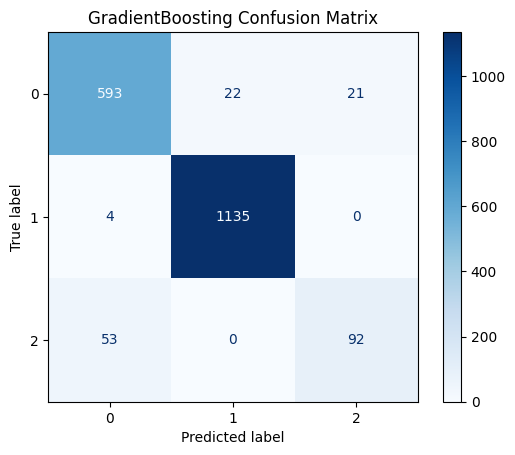

<Figure size 600x500 with 0 Axes>

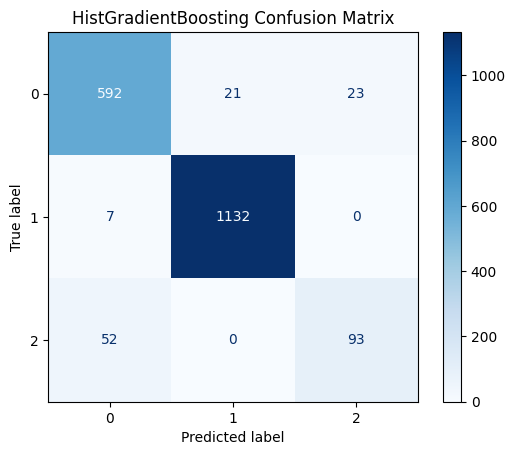

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
import matplotlib.pyplot as plt

# ----------------------
# Setup data
# ----------------------
df = pd.read_csv("./iot-dataset/iot-train-set.csv", sep=";")
unused_features = ['timestamp', 'zone_id', "day_of_week", 'temperature_celsius', 'special_event_flag']
categorical_cols = [ "time_of_day", "weather_condition"]
df.drop(unused_features, axis=1, inplace=True)
X = df.drop("lighting_action_class", axis=1)
y = df["lighting_action_class"]

# Identify numeric columns
numeric_cols = [col for col in X.columns if col not in categorical_cols]

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols)
    ]
)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ----------------------
# Tree-based models
# ----------------------
tree_models = {
    "DecisionTree": DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(random_state=42, class_weight="balanced", n_jobs=-1),
    "ExtraTrees": ExtraTreesClassifier(random_state=42, class_weight="balanced", n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "HistGradientBoosting": HistGradientBoostingClassifier(random_state=42)
}

# ----------------------
# Train, predict, and plot confusion matrix
# ----------------------
for name, model in tree_models.items():
    pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                               ("classifier", model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred, labels=y.unique())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y.unique())
    
    plt.figure(figsize=(6,5))
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(f"{name} Confusion Matrix")
    plt.show()


In [3]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# ----------------------
# Build pipeline
# ----------------------
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)

pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", rf_clf)
])

# ----------------------
# Parameter grid: n_estimators + max_depth
# ----------------------
param_grid = {
    "classifier__n_estimators": [50, 100, 200, 300],
    "classifier__max_depth": [None, 5, 10, 20]
}

# ----------------------
# Cross-validation setup
# ----------------------
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=cv,
    scoring="accuracy",   # or "f1_macro", "recall_macro"
    n_jobs=-1
)

grid_search.fit(X, y)

# ----------------------
# Results
# ----------------------
print("Best params:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)

# Optional: view all results in a table
cv_results = pd.DataFrame(grid_search.cv_results_)
print(cv_results[[
    "param_classifier__n_estimators",
    "param_classifier__max_depth",
    "mean_test_score"
]])


Best params: {'classifier__max_depth': 10, 'classifier__n_estimators': 200}
Best CV score: 0.9473958333333334
    param_classifier__n_estimators param_classifier__max_depth  \
0                               50                        None   
1                              100                        None   
2                              200                        None   
3                              300                        None   
4                               50                           5   
5                              100                           5   
6                              200                           5   
7                              300                           5   
8                               50                          10   
9                              100                          10   
10                             200                          10   
11                             300                          10   
12                              

Final Macro F1: 0.595764466644512
Final Accuracy: 0.9280208333333333


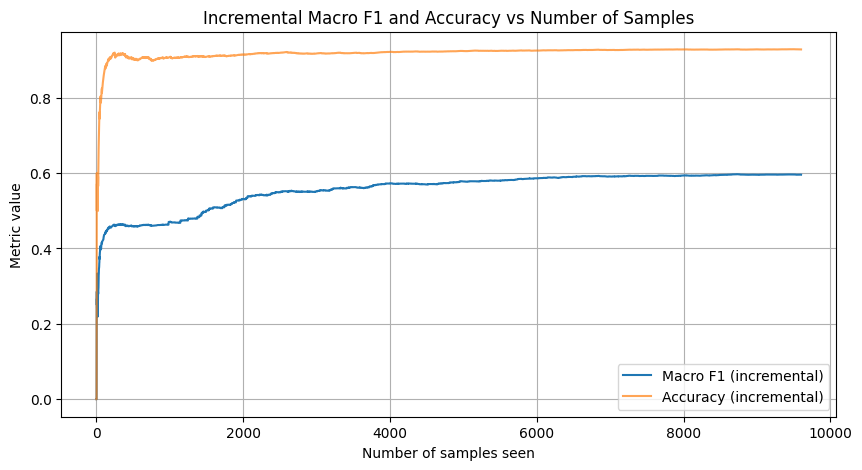

In [36]:
# Random Forest
import pandas as pd
import matplotlib.pyplot as plt
from river import compose, preprocessing, forest, metrics

# ----------------------
# Load data
# ----------------------
df = pd.read_csv("./iot-dataset/iot-train-set.csv", sep=";")
unused_features = ['timestamp', 'zone_id', "day_of_week", 'temperature_celsius', 'special_event_flag']
df.drop(unused_features, axis=1, inplace=True)

X = df.drop("lighting_action_class", axis=1)
y = df["lighting_action_class"]

categorical_cols = ["time_of_day", "weather_condition"]
numeric_cols = [col for col in X.columns if col not in categorical_cols]

# ----------------------
# Preprocessing pipeline
# ----------------------
categorical_transformer = compose.Select(*categorical_cols) | preprocessing.OneHotEncoder()
numeric_transformer = compose.Select(*numeric_cols)  # passthrough numeric features

preprocessor = compose.TransformerUnion(categorical_transformer, numeric_transformer)

# ----------------------
# Full pipeline with ARFClassifier
# ----------------------
model = compose.Pipeline(
    preprocessor,
    forest.ARFClassifier(n_models=200, max_depth=10, seed=42)
)

# ----------------------
# Incremental evaluation with Macro F1 and Accuracy
# ----------------------
metric_f1 = metrics.MacroF1()
metric_acc = metrics.Accuracy()
macro_f1_list = []
accuracy_list = []
num_samples = []

for i, (xi, yi) in enumerate(zip(X.to_dict(orient="records"), y), start=1):
    y_pred = model.predict_one(xi)
    
    # Update metrics
    metric_f1.update(yi, y_pred)
    metric_acc.update(yi, y_pred)
    
    model.learn_one(xi, yi)
    
    # Track metrics over time
    macro_f1_list.append(metric_f1.get())
    accuracy_list.append(metric_acc.get())
    num_samples.append(i)

print("Final Macro F1:", metric_f1.get())
print("Final Accuracy:", metric_acc.get())

# ----------------------
# Plot Macro F1 and Accuracy vs Number of Samples
# ----------------------
plt.figure(figsize=(10, 5))
plt.plot(num_samples, macro_f1_list, label="Macro F1 (incremental)")
plt.plot(num_samples, accuracy_list, label="Accuracy (incremental)", alpha=0.7)
plt.xlabel("Number of samples seen")
plt.ylabel("Metric value")
plt.title("Incremental Macro F1 and Accuracy vs Number of Samples")
plt.grid(True)
plt.legend()
plt.show()


Final Macro F1: 0.4945679167715412
Final Accuracy: 0.9002083333333334


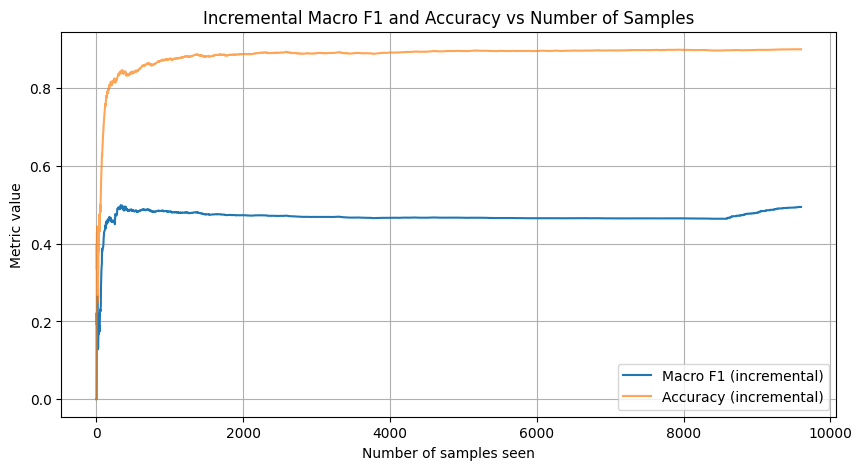

In [35]:
# Decision Tree
import pandas as pd
import matplotlib.pyplot as plt
from river import compose, preprocessing, tree, metrics

# ----------------------
# Load data
# ----------------------
df = pd.read_csv("./iot-dataset/iot-train-set.csv", sep=";")
unused_features = ['timestamp', 'zone_id', "day_of_week", 'temperature_celsius', 'special_event_flag']
df.drop(unused_features, axis=1, inplace=True)

X = df.drop("lighting_action_class", axis=1)
y = df["lighting_action_class"]

categorical_cols = ["time_of_day", "weather_condition"]
numeric_cols = [col for col in X.columns if col not in categorical_cols]

# ----------------------
# Preprocessing pipeline
# ----------------------
categorical_transformer = compose.Select(*categorical_cols) | preprocessing.OneHotEncoder()
numeric_transformer = compose.Select(*numeric_cols)  # passthrough numeric features

preprocessor = compose.TransformerUnion(categorical_transformer, numeric_transformer)

# ----------------------
# Full pipeline with ARFClassifier
# ----------------------
model = compose.Pipeline(
    preprocessor,
        tree.HoeffdingTreeClassifier(
        grace_period=200,    # controls how often to attempt splits
        max_depth=10,
    )
)

# ----------------------
# Incremental evaluation with Macro F1 and Accuracy
# ----------------------
metric_f1 = metrics.MacroF1()
metric_acc = metrics.Accuracy()
macro_f1_list = []
accuracy_list = []
num_samples = []

for i, (xi, yi) in enumerate(zip(X.to_dict(orient="records"), y), start=1):
    y_pred = model.predict_one(xi)
    
    # Update metrics
    metric_f1.update(yi, y_pred)
    metric_acc.update(yi, y_pred)
    
    model.learn_one(xi, yi)
    
    # Track metrics over time
    macro_f1_list.append(metric_f1.get())
    accuracy_list.append(metric_acc.get())
    num_samples.append(i)

print("Final Macro F1:", metric_f1.get())
print("Final Accuracy:", metric_acc.get())

# ----------------------
# Plot Macro F1 and Accuracy vs Number of Samples
# ----------------------
plt.figure(figsize=(10, 5))
plt.plot(num_samples, macro_f1_list, label="Macro F1 (incremental)")
plt.plot(num_samples, accuracy_list, label="Accuracy (incremental)", alpha=0.7)
plt.xlabel("Number of samples seen")
plt.ylabel("Metric value")
plt.title("Incremental Macro F1 and Accuracy vs Number of Samples")
plt.grid(True)
plt.legend()
plt.show()

Final Macro F1: 0.5579217646780574
Final Accuracy: 0.8598958333333333


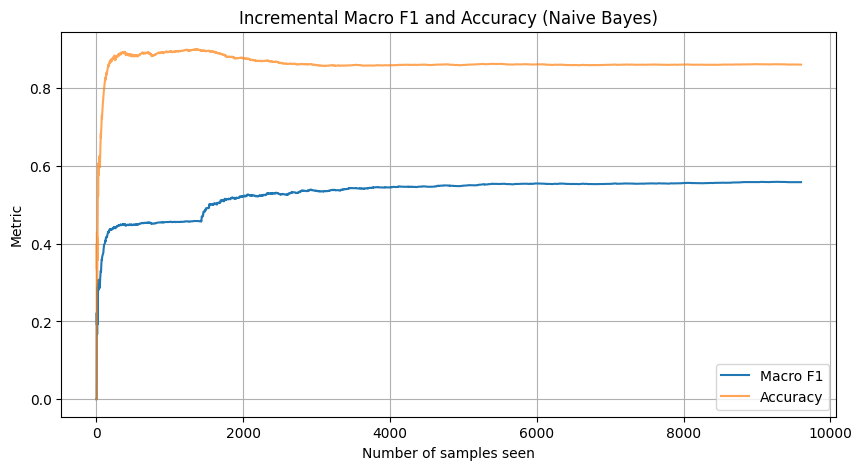

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from river import compose, preprocessing, naive_bayes, metrics

# ----------------------
# Load data
# ----------------------
df = pd.read_csv("./iot-dataset/iot-train-set.csv", sep=";")
unused_features = ['timestamp', 'zone_id', "day_of_week", 'temperature_celsius', 'special_event_flag']
df.drop(unused_features, axis=1, inplace=True)

X = df.drop("lighting_action_class", axis=1)
y = df["lighting_action_class"]

categorical_cols = ["time_of_day", "weather_condition"]
numeric_cols = [col for col in X.columns if col not in categorical_cols]

# ----------------------
# Preprocessing pipeline
# ----------------------
# Only encode categorical features; numeric features stay as-is
categorical_transformer = compose.Select(*categorical_cols) | preprocessing.OneHotEncoder()
numeric_transformer = compose.Select(*numeric_cols)

preprocessor = compose.TransformerUnion(categorical_transformer, numeric_transformer)

# ----------------------
# Naive Bayes model
# ----------------------
model = compose.Pipeline(
    preprocessor,
    naive_bayes.GaussianNB()  # Gaussian Naive Bayes handles numeric features
)

# ----------------------
# Incremental evaluation
# ----------------------
metric_f1 = metrics.MacroF1()
metric_acc = metrics.Accuracy()
conf_matrix = metrics.ConfusionMatrix()
macro_f1_list = []
accuracy_list = []
num_samples = []

for i, (xi, yi) in enumerate(zip(X.to_dict(orient="records"), y), start=1):
    y_pred = model.predict_one(xi)
    
    # Update metrics
    metric_f1.update(yi, y_pred)
    metric_acc.update(yi, y_pred)
    conf_matrix.update(yi, y_pred)
    
    # Learn incrementally
    model.learn_one(xi, yi)
    
    macro_f1_list.append(metric_f1.get())
    accuracy_list.append(metric_acc.get())
    num_samples.append(i)

print("Final Macro F1:", metric_f1.get())
print("Final Accuracy:", metric_acc.get())

# ----------------------
# Plot Macro F1 and Accuracy
# ----------------------
plt.figure(figsize=(10,5))
plt.plot(num_samples, macro_f1_list, label="Macro F1")
plt.plot(num_samples, accuracy_list, label="Accuracy", alpha=0.7)
plt.xlabel("Number of samples seen")
plt.ylabel("Metric")
plt.title("Incremental Macro F1 and Accuracy (Naive Bayes)")
plt.grid(True)
plt.legend()
plt.show()


KNN Final Macro F1: 0.4650190760124268
KNN Final Accuracy: 0.8107291666666666


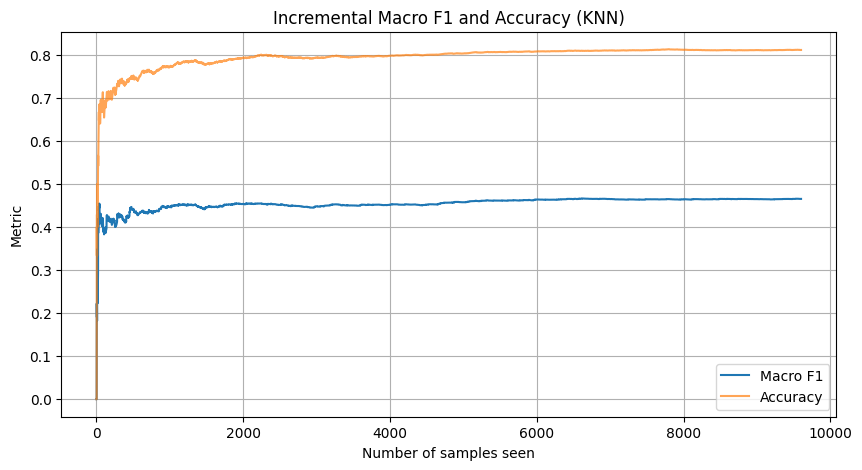

In [43]:
#KNN
from river import neighbors

# KNN model
model_knn = compose.Pipeline(
    preprocessor,
    neighbors.KNNClassifier(n_neighbors=5)  # adjust neighbors/window_size
)

# Incremental evaluation
metric_f1 = metrics.MacroF1()
metric_acc = metrics.Accuracy()
conf_matrix = metrics.ConfusionMatrix()
macro_f1_list = []
accuracy_list = []
num_samples = []

for i, (xi, yi) in enumerate(zip(X.to_dict(orient="records"), y), start=1):
    y_pred = model_knn.predict_one(xi)
    metric_f1.update(yi, y_pred)
    metric_acc.update(yi, y_pred)
    conf_matrix.update(yi, y_pred)
    model_knn.learn_one(xi, yi)
    
    macro_f1_list.append(metric_f1.get())
    accuracy_list.append(metric_acc.get())
    num_samples.append(i)

print("KNN Final Macro F1:", metric_f1.get())
print("KNN Final Accuracy:", metric_acc.get())

# ----------------------
# Plot Macro F1 and Accuracy
# ----------------------
plt.figure(figsize=(10,5))
plt.plot(num_samples, macro_f1_list, label="Macro F1")
plt.plot(num_samples, accuracy_list, label="Accuracy", alpha=0.7)
plt.xlabel("Number of samples seen")
plt.ylabel("Metric")
plt.title("Incremental Macro F1 and Accuracy (KNN)")
plt.grid(True)
plt.legend()
plt.show()
